In [1]:
# Importing necessary libraries
# TODO:clean this
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import seaborn as sns
from cnnmodel import ModelSubClassing

2024-07-11 20:36:44.435898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 20:36:44.477830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 20:36:45.152942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#df for 64 embeddings
df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_mood_embeddings.pkl')

In [3]:
df.head(10)

,clip_id,mp3_path,tags,caption_embedding
0,11,american_bach_soloists-j_s__bach_solo_cantatas...,quiet,"[74.27188, 52.338303, 113.25154, 114.274376, 0..."
1,21,lvx_nova-lvx_nova-01-contimune-233-262.mp3,fast,"[156.48071, 51.32945, 134.52489, 70.58329, 33...."
2,23,lvx_nova-lvx_nova-01-contimune-291-320.mp3,fast,"[69.12758, 0.0, 110.159035, 115.53406, 52.5800..."
3,39,american_bach_soloists-heinrich_schutz__musica...,slow,"[68.347694, 0.0, 77.29853, 138.75955, 0.0, 34...."
4,51,american_bach_soloists-heinrich_schutz__musica...,quiet,"[23.718048, 31.212835, 117.077995, 82.57075, 0..."
5,66,american_bach_soloists-heinrich_schutz__musica...,slow,"[42.90297, 13.43043, 120.5256, 80.96025, 0.0, ..."
6,90,ralph_meulenbroeks-gambomania-01-my_mistress_h...,fast,"[42.759563, 44.877903, 26.87345, 79.28824, 0.0..."
7,92,ralph_meulenbroeks-gambomania-01-my_mistress_h...,slow,"[55.28583, 8.733855, 57.117912, 82.90737, 0.0,..."
8,94,ralph_meulenbroeks-gambomania-01-my_mistress_h...,soft,"[76.72567, 24.952251, 44.662674, 84.696236, 0...."
9,98,philharmonia_baroque_orchestra-jake_heggie__to...,fast,"[62.72459, 48.908978, 21.662413, 67.19001, 0.0..."


## Training the model

In [4]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [5]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

In [6]:
data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
  filename_npy = str(filename[:-4]) + '.npy'
  file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
  img = np.load(file_path)
  data.append(add_gauss_noise(img))

  # To ensure that the files are getting loaded in the correct order
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)

american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-291-320.mp3
lvx_nova-lvx_nova-01-contimune-233-262.mp3
lvx_nova-lvx_nova-01-contimune-291-320.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-0-29.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-349-378.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-784-813.mp3
ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-59-88.mp3
ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-117-146.mp3
ralph_meulenbroeks-gambomania-01-my_mistress_hath_a_pritty_thing_tobias_hume-175-204.mp3
philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-88-117.mp3


In [7]:
# Caption Embeddings
embeddings = df['caption_embedding']

In [8]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(5997, 128, 1255)

In [9]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
X_train_spec, X_val_spec, X_train_embed, X_val_embed, y_train, y_val = train_test_split(data, embeddings, pd.get_dummies(df['tags']), test_size=0.1, random_state=42)

In [10]:
# convert this array of arrays into a 2D NumPy array
X_train_embed_array = np.stack(X_train_embed, axis=0)
# convert the 2D NumPy array to a TensorFlow tensor
X_train_embed_tensor = tf.convert_to_tensor(X_train_embed_array, dtype=tf.float32)

# convert the 1D array of arrays into a proper 2D NumPy array
X_val_embed_array = np.stack(X_val_embed, axis=0)
# convert the 2D NumPy array to a TensorFlow tensor
X_val_embed_tensor = tf.convert_to_tensor(X_val_embed_array, dtype=tf.float32)

2024-07-11 20:37:12.255637: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
# convert training data to tensors
X_train_spec = tf.convert_to_tensor(X_train_spec, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# convert validation data to tensors
X_val_spec = tf.convert_to_tensor(X_val_spec, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [12]:
# initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train_spec)

In [13]:
# define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

7

In [14]:
class ModelSubClassing(keras.Model):
    def __init__(self, num_classes, l1_reg=0.01, l2_reg=0.001, alpha = 0.001):
        super().__init__()
        
        # Define L1 and L2 regularizer
        self.l1_l2_regularizer = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
        # self.l2_regularizer = regularizers.l2(l2_reg)
        
        # Define alpha the loss regulator
        self.alpha = alpha
        
        # number of classes
        self.num_classes = num_classes
        
        # Initialize layers as None
        self.conv1 = None
        self.max1 = None
        self.bn1 = None
        self.conv2 = None
        self.bn2 = None
        self.max2 = None
        self.drop1 = None
        self.conv3 = None
        self.bn3 = None
        self.max3 = None
        self.drop2 = None
        self.flatten = None
        self.dense128 = None
        self.dense128_activation = None
        self.dense128_do = None
        self.dense64 = None
        self.dense64_activation = None
        self.dense_out = None
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.accuracy = keras.metrics.CategoricalAccuracy(name="accuracy")

    def build(self, input_shape):
        # Create layers
        self.conv1 = Conv2D(32, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.max1  = MaxPooling2D(3)
        self.bn1   = BatchNormalization(momentum=0.9)

        self.conv2 = Conv2D(64, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.bn2   = BatchNormalization(momentum=0.9)
        self.max2  = MaxPooling2D(3)
        self.drop1 = Dropout(0.3)

        self.conv3 = Conv2D(128, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.bn3   = BatchNormalization(momentum=0.9)
        self.max3  = MaxPooling2D(3)
        self.drop2 = Dropout(0.3)

        self.flatten = Flatten()
        self.dense128 = Dense(128)
        self.dense128_activation = Activation('relu')
        self.dense128_do = Dropout(0.3)
        self.dense64 = Dense(64)
        self.dense64_activation = Activation('relu')
        self.dense_out = Dense(self.num_classes, activation="softmax")
        
        super().build(input_shape)

    def call(self, inputs, training=None):
        # Unpack the inputs
        mel_spectrogram = inputs[0]

        # Forward pass: block 1
        x = self.conv1(mel_spectrogram)
        x = self.max1(x)
        x = self.bn1(x, training=training)

        # Forward pass: block 2
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.max2(x)
        x = self.drop1(x, training=training)

        # Forward pass: block 3
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.max3(x)
        x = self.drop2(x, training=training)

        # Flatten and dense layers
        x = self.flatten(x)
        x_dense128 = self.dense128(x)
        x_dense128_act = self.dense128_activation(x_dense128)
        #I removed the l1_l2 reg
        if training:
            x_dense128_act = self.dense128_do(x_dense128_act)
        x_dense64 = self.dense64(x_dense128_act)
        x_dense64_act = self.dense64_activation(x_dense64)
        y_hat = self.dense_out(x_dense64_act)
        
        return y_hat, x_dense64


    def train_step(self, data):
        # Unpack the data
        (mel_spectrogram, caption_embedding), y = data

        with tf.GradientTape() as tape: 
        #here we get the gradients of the trainable weights with this loss
            y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=True)  # Forward pass
            # Compute the standard loss value
            loss = self.compiled_loss(y, y_pred)
            custom_loss = self.custom_loss(caption_embedding, x_dense64)
            total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

        # Compute gradients
        gradients = tape.gradient(total_loss, self.trainable_variables)

        # Update weights
        # self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(total_loss)
        self.accuracy.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.accuracy.result(),
            "crossentropy_loss": loss,
            "embedding_loss": custom_loss,
            "total_loss": total_loss
        }

        
    def test_step(self, data):
        # Unpack the data
        (mel_spectrogram, caption_embedding), y = data

        
        y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=False)  # Forward pass
        # Compute the standard loss value
        loss = self.compiled_loss(y, y_pred)
        custom_loss = self.custom_loss(caption_embedding, x_dense64)
        total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(total_loss)
        self.accuracy.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.accuracy.result(),
            "crossentropy_loss": loss,
            "embedding_loss": custom_loss,
            "total_loss": total_loss
        }
        
    # Add a custom loss method in the model
    def custom_loss(self, caption_embedding, x_dense64):
        return tf.reduce_mean(tf.square(caption_embedding - x_dense64))

    #new
    @property
    def metrics(self):
        # List all metrics to be reset after each epoch
        return [self.loss_tracker, self.accuracy]
    
# Creating the class object
model = ModelSubClassing(num_classes)

# Compile the model
adam_opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
rlronp = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, verbose=1)

history = model.fit(
    (X_train_spec, X_train_embed_tensor),
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=((X_val_spec, X_val_embed_tensor), y_val),
    callbacks = [early_stopper, rlronp]
)

Epoch 1/100


/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:612: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 330ms/step - accuracy: 0.4206 - crossentropy_loss: 28.8598 - embedding_loss: 10492.6074 - loss: 40.9915 - total_loss: 39.3236 - val_accuracy: 0.5300 - val_loss: 36.0959 - learning_rate: 1.0000e-04
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 327ms/step - accuracy: 0.5297 - crossentropy_loss: 22.5842 - embedding_loss: 10413.0098 - loss: 34.4995 - total_loss: 32.9746 - val_accuracy: 0.5250 - val_loss: 29.9553 - learning_rate: 1.0000e-04
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.5617 - crossentropy_loss: 16.9942 - embedding_loss: 10337.8750 - loss: 28.5885 - total_loss: 27.3151 - val_accuracy: 0.5933 - val_loss: 24.7807 - learning_rate: 1.0000e-04
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.5621 - crossentropy_loss: 12.5851 - embedding_loss: 10140.9619 - loss: 23.7433 - total_loss: 22.7135 - val_accuracy: 0.5283 - val_loss: 20.8985 - learning_rate: 1.0000e-04
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s

In [16]:
val_data = ((X_val_spec, X_val_embed_tensor), y_val)
train_data = ((X_train_spec, X_train_embed_tensor), y_train)

# evaluate on the training data
train_loss, train_accuracy = model.evaluate((X_train_spec, X_train_embed_tensor), y_train, verbose = 0)
print(f'Training Accuracy: {train_accuracy}, Training Loss: {train_loss}')

# evaluate on the validation data
val_loss, val_accuracy = model.evaluate((X_val_spec, X_val_embed_tensor), y_val, verbose = 0)
print(f'Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

Training Accuracy: 0.8847507834434509, Training Loss: 4.314479351043701
Validation Accuracy: 0.6850000023841858, Validation Loss: 5.012392997741699


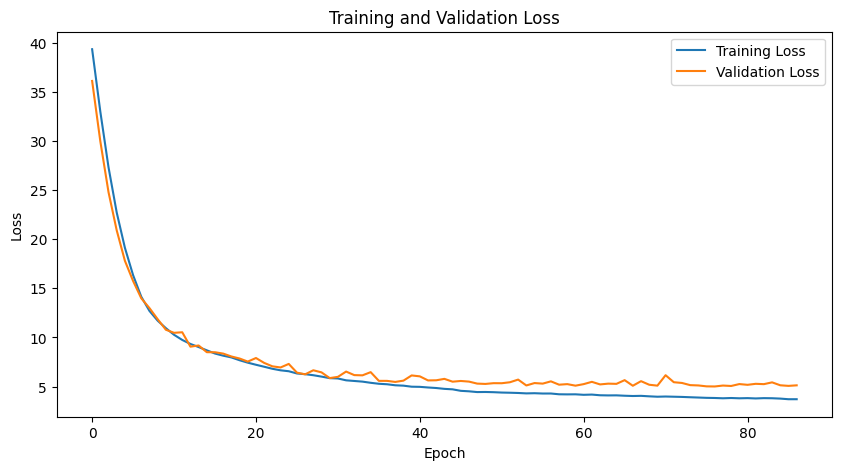

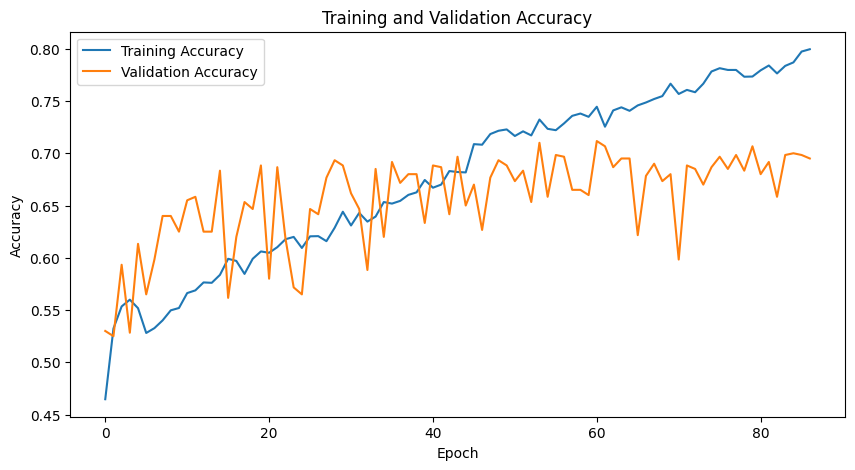

In [17]:
# plot a graph for training and validation loss
plt.figure(figsize=(10, 5)) 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot a graph for training and validation accuracy
plt.figure(figsize=(10, 5)) 
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


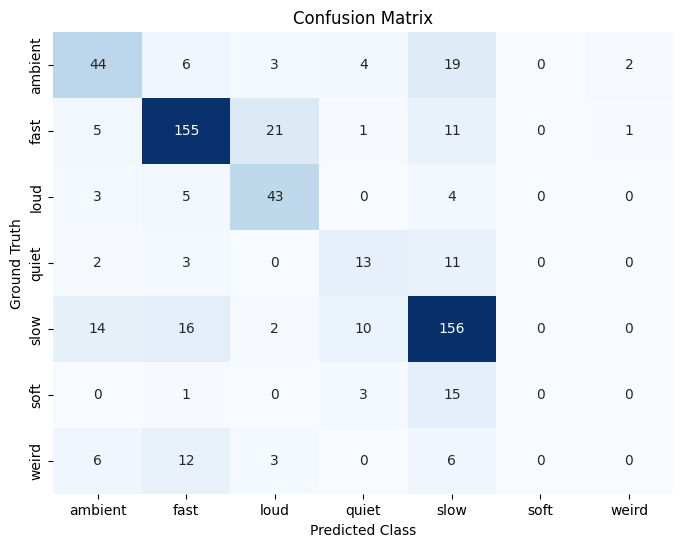

In [26]:
# Get predictions
predictions = model.predict((X_val_spec, X_val_embed_tensor))
predicted_labels = np.argmax(predictions[0], axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

# Define class labels
class_labels = pd.get_dummies(df['tags']).columns.tolist()

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Create a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})
# Get unique class labels
unique_labels = sorted(comparison_table['Ground Truth'].unique())

# Create confusion matrix
conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()


In [35]:
y_val_df = pd.DataFrame(y_val, columns = pd.get_dummies(df['tags']).columns.tolist())
y_val_df = y_val_df.set_index()
y_val_df['New'] = y_val_df.values.argmax(1)+1

In [36]:
y_val_df.New.value_counts()

New
5    198
2    194
1     78
3     55
4     29
7     27
6     19
Name: count, dtype: int64

In [37]:
y_val_df

,ambient,fast,loud,quiet,slow,soft,weird,New
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
596,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
